# 목차
1. 분석의 방향
2. 데이터 Overview
    + 스키마 분석
    + 데이터 크기
4. 데이터 전처리
    +  데이터 병합
    + 중복 제거
    + 결측치 처리
    + 이상치 탐지 및 처리
5. 탐색적 분석(EDA)
    + 기초 통계량 요약
    + 범주형 변수 분석
    + 수치형 변수 분석
    + 시각화(분포, box, scatter, heatmap 등)
    + 상관관계 분석
6. 주요 인사이트
7. 결론 및 회고


-------------------
# 1. 분석의 방향
중고차를 사려는 사람이 가장 먼저 결정하는 건 보통 예산 범위다.  
그리고 예산이 정해지면 자연스럽게 브랜드를 선택하는데, 브랜드는 이미지, 성능, 옵션 기대치를 함께 끌고 들어오기 때문에 처음 필터링에 큰 영향을 준다.

이번 분석은 중고차 판매자(공급자)의 입장에서 사람들이 어떤 판매 가격대에 가장 많이 몰려 있는지, 그리고 그 판매 가격대에서 어떤 브랜드가 상대적으로 우위를 보이는지를 확인하려고 한다.  
이를 통해 판매 가격대별 인기 브랜드를 이해하고, 재고를 어떤 조합으로 맞추면 더 효율적인 공급 전략을 만들 수 있는지 탐색한다.

물론 실제 구매에서는 차량 상태나 개인 취향 같은 변수들이 크게 작용하기에 이러한 상관관계도 밝히고자 한다.
중고차 데이터분석을 통해 ['판매 가격', '브랜드명']에 따른 고객의 수요를 파악한다.

### 접근방향
+ 판매 가격대별 수요의 분포를 알고, 고객에게 소개해줄 라인업을 구성할 수 있지 않을까?
  + 판매 가격대별 브랜드의 선호도는?
+ 차량의 상태를 어떻게 판단할 수 있을까?

### 데이터 한계
1. 판매가 완료된 데이터인지 판매 중인 리스트의 데이터인지에 대한 정보가 부족하다.
2. 운행 기록 단위(miles), 연료 명칭(Petrol), 배출등급(Euro)의 요소로 영국으로 짐작이 되나, 확실한 국가의 유추가 힘들다.
3. 판매 가격에 대한 단위가 존재하지 않아서, 가격 차이가 얼마나 큰 의미를 가지는지 짐작하기 힘들다. 중고차가 가질 수 있는 가격인지를 판단하기 어렵다.
   (싼 가격이 얼마나 싼지, 비싼 가격이 얼마나 비싼지)

-------------------
# 2. 데이터 Overview

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA

cars_df = pd.read_csv('cars.csv')
brand_df = pd.read_csv('brand.csv')

cars_df.columns=['등록 차량','판매 가격','운행 기록(마일)','등록년도','이전 차주(명)','연료','차체','엔진','기어','도어 수','시트 수','배출등급','정비 기록']
brand_df.columns=['브랜드','국가']

### Cars_df

In [2]:
cars_df.head()

,등록 차량,판매 가격,운행 기록(마일),등록년도,이전 차주(명),연료,차체,엔진,기어,도어 수,시트 수,배출등급,정비 기록
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


In [3]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   등록 차량      3687 non-null   object 
 1   판매 가격      3687 non-null   int64  
 2   운행 기록(마일)  3687 non-null   int64  
 3   등록년도       3687 non-null   int64  
 4   이전 차주(명)   2276 non-null   float64
 5   연료         3687 non-null   object 
 6   차체         3687 non-null   object 
 7   엔진         3642 non-null   object 
 8   기어         3687 non-null   object 
 9   도어 수       3662 non-null   float64
 10  시트 수       3652 non-null   float64
 11  배출등급       3600 non-null   object 
 12  정비 기록      540 non-null    object 
dtypes: float64(3), int64(3), object(7)
memory usage: 374.6+ KB


In [4]:
cars_df.describe(include='all')

,등록 차량,판매 가격,운행 기록(마일),등록년도,이전 차주(명),연료,차체,엔진,기어,도어 수,시트 수,배출등급,정비 기록
count,3687,3687.000000,3.687000e+03,3687.000000,2276.000000,3687,3687,3642,3687,3662.000000,3652.000000,3600,540
unique,455,NaN,NaN,NaN,NaN,6,10,34,2,NaN,NaN,6,1
top,VAUXHALL CORSA,NaN,NaN,NaN,NaN,Petrol,Hatchback,1.6L,Manual,NaN,NaN,Euro 5,Full
freq,223,NaN,NaN,NaN,NaN,2362,2280,736,2870,NaN,NaN,1257,540
mean,NaN,5787.301058,8.132854e+04,2011.846216,2.807557,NaN,NaN,NaN,NaN,4.321409,4.900329,NaN,NaN
std,NaN,4480.629885,3.941718e+04,5.082387,1.546028,NaN,NaN,NaN,NaN,0.986760,0.577046,NaN,NaN
min,NaN,400.000000,1.000000e+00,1953.000000,1.000000,NaN,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN
25%,NaN,2490.000000,5.698400e+04,2008.000000,2.000000,NaN,NaN,NaN,NaN,3.000000,5.000000,NaN,NaN
50%,NaN,4000.000000,8.000000e+04,2012.000000,3.000000,NaN,NaN,NaN,NaN,5.000000,5.000000,NaN,NaN
75%,NaN,7995.000000,1.030000e+05,2015.500000,4.000000,NaN,NaN,NaN,NaN,5.000000,5.000000,NaN,NaN


In [5]:
cars_df.isna().mean()*100

등록 차량         0.000000
판매 가격         0.000000
운행 기록(마일)     0.000000
등록년도          0.000000
이전 차주(명)     38.269596
연료            0.000000
차체            0.000000
엔진            1.220504
기어            0.000000
도어 수          0.678058
시트 수          0.949281
배출등급          2.359642
정비 기록        85.353946
dtype: float64

### brand_df

In [6]:
brand_df.head()

,브랜드,국가
0,skoda,Czech Republic
1,vauxhall,United Kingdom
2,hyundai,South Korea
3,mini,United Kingdom
4,ford,United States


In [7]:
brand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   브랜드     48 non-null     object
 1   국가      48 non-null     object
dtypes: object(2)
memory usage: 900.0+ bytes


### 데이터 설명
+ 스키마  
   이번 분석에서는 2가지의 table이 존재한다.
  + cars_df   
    1. title : 등록 차량 `object`
    2. Price : 판매 가격 `int`
    3. Mileage(miles) : 운행 기록(마일) `int`
    4. Registration_Year : 등록년도 `int`
    5. Previous Owners : 이전 차주(명) `float`
    6. Fuel type : 연료 `object`
    7. Body type : 차체 `object`
    8. Engine : 엔진 `object`
    9. Gearbox : 기어 `object`
    10. Doors : 도어 수 `float`
    11. Seats : 시트 수 `float`
    12. Emission Class : 배출등급 `object`
    13. Service history : 정비 기록 `object`<br><br>
  + brand_df  
    1. brand : 브랜드 `object`
    2. country : 국가 `object`<br><br>
+ 데이터 크기
    + cars_df : `3687 rows * 13 columns`
    + brand_df  : `48 rows * 2 columns`<br><br>
+ 특이사항
    + 데이터 병합  
cars 데이터 내 '**등록차량**' 속성이 두 어절로 이루어져 있으며, 각각 '브랜드'와 '모델명'을 합쳐서 표기했다.  
brand 데이터와의 병합을 위해서 각 어절을 분리하고 소문자로 통일하여 형식을 맞춘다.
    + 결측치
      + 이전 차주(명) : 38%
      + 엔진 : 1%
      + 도어 수 : 1%
      + 시트 수 : 1%
      + 배출등급 : 2%
      + 정비 기록 : 85%<br>  
        '**이전 차주(명)**'과 '**정비 기록**'의 경우 데이터 비율의 상당량을 차지하므로, 단순히 누락된 행을 제거하여 분석을 진행할 수 없다.  
        두 속성의 경우 개인 차량 관리에서 빼놓지 않고 기록하는 데이터이기에 의도적으로 기재하지 않을 항목이 아니며, 이를 데이터 누락으로 처리하여 확인할 수 없는 값임을 표시한다.<br><br>
        '**엔진**','**도어 수**','**시트 수**','**배출등급**'은 차량 브랜드, 모델명, 등록년도가 같다면 같은 값을 적용할 수 있도록 한다.  
        등록년도와 연식은 다른 개념이기에 실제로는 다를 수 있으나, 등록년도와 연식은 비슷할 것이라는 가정 하에 결측치를 보충한다. 이후의 결측치는 제거한다<br><br>
  
    + 목표 데이터 형식
      + 등록차량 : `string`
      + 연료 : `string`
      + 차체 : `string`
      + 엔진 : `float`
      + 기어 : `string`
      + 배출등급 : `int`
      + 정비 기록 : `bool`
      + 국가 : `string`<br><br>
    + 이상치 확인 필요
      + 판매 가격 : 400 
      + 운행기록(마일) : 1
      + 이전 차주(명) : 9

--------------------
# 데이터 전처리
## 중복 제거

In [8]:
len(cars_df[cars_df.duplicated()])

828

In [9]:
cars_df = cars_df.drop_duplicates()

### 요약
같은 값이 둘 이상이 반복되는 828개의 행을 발견하였다.  
각각 다른 차량의 기록이라고 생각할 수 있겠으나, **모델명/판매 가격/운행 기록(마일)/등록년도/정비기록**처럼 차량마다 다를 수 있는 항목에서 동일한 값을 가졌다는 것은 확률상 불가능하다.

따라서, 동일한 차량의 데이터라고 판단하였으며 중복 제거를 통해 **828 행을 제거**하였다.

#### 데이터 크기
제거된 데이터 크기 : 828 rows (약 22.4%)  
남은 데이터 크기 : 2859 rows

--------------
## 데이터 병합

In [10]:
cars_df['등록 차량'].unique()

array(['SKODA FABIA', 'VAUXHALL CORSA', 'HYUNDAI I30', 'MINI HATCH',
       'HYUNDAI COUPE', 'FORD FOCUS', 'VOLVO 740', 'PEUGEOT 207',
       'FORD FIESTA', 'VAUXHALL INSIGNIA', 'BMW 3 SERIES', 'CITROEN C1',
       'CITROEN C4', 'VAUXHALL ASTRA', 'FORD MONDEO',
       'MERCEDES-BENZ A180', 'PEUGEOT 407', 'FORD KA',
       'MERCEDES-BENZ A CLASS', 'MAZDA MAZDA2', 'SAAB 9-3',
       'VOLKSWAGEN POLO', 'BMW 1 SERIES', 'HONDA ACCORD',
       'VOLKSWAGEN BEETLE', 'MG MG6', 'FORD C-MAX', 'HONDA CIVIC',
       'TOYOTA AURIS', 'VOLVO S40', 'SEAT IBIZA', 'PEUGEOT 308',
       'VAUXHALL MERIVA', 'MERCEDES-BENZ B CLASS', 'MAZDA MAZDA3',
       'NISSAN 350 Z', 'ALFA ROMEO MITO', 'RENAULT FLUENCE',
       'VOLKSWAGEN PASSAT', 'KIA SPORTAGE', 'CITROEN XM',
       'VAUXHALL ANTARA', 'NISSAN NOTE', 'BMW 5 SERIES', 'HONDA CR-V',
       'PROTON SAVVY', 'NISSAN MICRA', 'FIAT PANDA', 'RENAULT MEGANE',
       'RENAULT CLIO', 'HYUNDAI I20', 'CITROEN C3', 'AUDI A6 SALOON',
       'TOYOTA YARIS', 'FIAT 500', 

In [11]:
brand_df['브랜드'].unique()

array(['skoda', 'vauxhall', 'hyundai', 'mini', 'ford', 'volvo', 'peugeot',
       'bmw', 'citroen', 'mercedes-benz', 'mazda', 'saab', 'volkswagen',
       'honda', 'mg', 'toyota', 'seat', 'nissan', 'alfa', 'renault',
       'kia', 'proton', 'fiat', 'audi', 'mitsubishi', 'lexus', 'land',
       'chevrolet', 'suzuki', 'dacia', 'daihatsu', 'jeep', 'jaguar',
       'chrysler', 'rover', 'ds', 'daewoo', 'dodge', 'porsche', 'subaru',
       'infiniti', 'abarth', 'smart', 'marcos', 'maserati', 'ssangyong',
       'lagonda', 'isuzu'], dtype=object)

In [12]:
# 형식 변환
cars_df['등록 차량'] = cars_df['등록 차량'].astype('string')
brand_df['브랜드'] = brand_df['브랜드'].astype('string')
# 소문자 변경
cars_df['등록 차량'] = cars_df['등록 차량'].str.lower()
# 앞 어절을 추출하여 브랜드 피쳐 생성
cars_df['브랜드'] = cars_df['등록 차량'].str.split().str[0]
# 뒷 어절을 추출하여 모델명 피쳐 생성
cars_df['모델명'] = cars_df['등록 차량'].str.split().str[1]
# 브랜드, 모델명의 피쳐와 중복되므로 등록 차량 피쳐 drop
cars_df = cars_df.drop(['등록 차량'],axis=1)
# 브랜드를 키로 설정하여 cars_df 기준 brand_df를 병합
cars_df = cars_df.merge(brand_df, how='left', on='브랜드')
# cars_df에서 국가 피쳐에 대한 결측치가 있는지 확인
cars_df['국가'].isna().sum()

np.int64(0)

### 요약
cars_df의 경우 '**등록차량**'이 `'브랜드'+'모델명'`의 형식이기에 이를 분리하고, 대문자로 이루어진 이름을 소문자로 바꾸어 brand의 형식과 일치시켜주었다.  

이 과정에서,
1. **'브랜드' 피쳐와 '모델명' 피쳐를 생성**하였으며,
2. **'등록 차량'의 피쳐가 중복됨으로 삭제**하였다.
3. 병합의 결과 모든 cars_df의 행이 brand_df와 결합하여 새로운 **'국가' 피쳐가 생성**되었다.

--------------------
## 결측치 처리

In [13]:
cars_df.isna().agg(['mean','sum']).T

,mean,sum
판매 가격,0.000000,0.0
운행 기록(마일),0.000000,0.0
등록년도,0.000000,0.0
이전 차주(명),0.343827,983.0
연료,0.000000,0.0
차체,0.000000,0.0
엔진,0.005946,17.0
기어,0.000000,0.0
도어 수,0.008744,25.0
시트 수,0.012242,35.0


In [14]:
# 각각의 결측치를 보충하기 전에 해당 데이터가 특정 속성에 결측이 있었다는 피쳐를 생성하여, 결측치가 가격에 영향이 있는지를 파악하도록 한다.
cars_df['nan_이전 차주(명)']=cars_df['이전 차주(명)'].isna()

### 이전 차주(명)

In [15]:
# 이전 차주에 대해 알 수 없다는 값으로 99를 입력
cars_df['이전 차주(명)'] = cars_df['이전 차주(명)'].fillna(99)

### 엔진, 도어 수, 시트 수, 배출등급

In [16]:
# 엔진의 경우 : (같은 브랜드, 모델, 등록년도라면 & cars_df['엔진']이 비지 않았다면) 그대로 값을 가져오기
nan_list=['엔진','도어 수','시트 수','배출등급']
for i in nan_list:
    # 대표값 추출
    unique_list=cars_df.groupby(['브랜드','모델명','등록년도'])[i].first()
    cars_df[i] = cars_df[i].fillna(cars_df[['브랜드','모델명','등록년도']].apply(lambda x: unique_list.get((x['브랜드'], x['모델명'], x['등록년도'])),axis=1))

In [17]:
cars_df.isna().agg(['mean','sum']).T
# 엔진 9개,도어 수 11개, 시트 수 11개 배출등급 19개의 결측치 해결

,mean,sum
판매 가격,0.000000,0.0
운행 기록(마일),0.000000,0.0
등록년도,0.000000,0.0
이전 차주(명),0.000000,0.0
연료,0.000000,0.0
차체,0.000000,0.0
엔진,0.002798,8.0
기어,0.000000,0.0
도어 수,0.004897,14.0
시트 수,0.008395,24.0


In [18]:
# 엔진, 도어 수, 시트 수의 나머지 결측치 제거
cars_df= cars_df.dropna(subset=['엔진','도어 수','시트 수'])

### 배출등급

In [19]:
cars_df['배출등급'].value_counts()

배출등급
Euro 5    1106
Euro 4     872
Euro 6     686
Euro 3     131
Euro 2      17
Euro 1       1
Name: count, dtype: int64

In [20]:
cars_df['배출등급'] = pd.to_numeric(cars_df['배출등급'].astype('string').str.split().str[-1])
cars_df= cars_df.dropna(subset='배출등급')

### 정비 기록

In [21]:
cars_df['정비 기록'].value_counts()

정비 기록
Full    443
Name: count, dtype: int64

In [22]:
cars_df['정비 기록'] = cars_df['정비 기록'].fillna(0)
cars_df['정비 기록'] = cars_df['정비 기록'].replace({'Full':1}).astype('int')

C:\Users\songj\AppData\Local\Temp\ipykernel_19104\776919085.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cars_df['정비 기록'] = cars_df['정비 기록'].replace({'Full':1}).astype('int')


### 요약
1. '이전 차주(명)'  
   + 중고차이므로 최소 1 이상의 값을 가져야하고, 의도적으로 결측값을 넣을 수 없으므로 누락된 값을 의미한다.
   + 시각화 단계에서는 NaN 값을, 모델링 단계에서는 중앙값을 넣을 수 있도록, 결측치 처리 단계에서는 확인이 편한 99의 값을 입력한다.
   + 결측치 : 99
2. '엔진', '도어 수', '시트 수', '배출등급'  
   + 차량에 따라 정해지는 값이며 모델과 연식이 같을 경우 같은 값을 가질 가능성이 크다. 따라서 같은 '모델:연식'에서 각 속성에 값으로 결측치를 일부 제거하였다.
   + 엔진 9개,도어 수 11개, 시트 수 11개 배출등급 19개의 결측치 해결
   + 결측치 : 제거
3. '배출등급'
   + 'Euro '+숫자의 형식을 가지고 있기에 숫자만 추출하였다.
   + 결측치 : 제거
4. '정비 기록'
   + 결측값은 정비를 하지 않았거나, 누락된 것으로 해석이 가능하다. 또한 정비 기록은 'Full' 하나의 형식만 존재한다.
   + Full : 1 / 결측치 : 0

#### 데이터 크기
제거된 데이터 크기 : 46 rows (약 1.6%)  
남은 데이터 크기 : 2813 rows

---------------------
## Type 변경

In [23]:
cars_df.dtypes

판매 가격             int64
운행 기록(마일)         int64
등록년도              int64
이전 차주(명)        float64
연료               object
차체               object
엔진               object
기어               object
도어 수            float64
시트 수            float64
배출등급            float64
정비 기록             int64
브랜드              object
모델명              object
국가               object
nan_이전 차주(명)       bool
dtype: object

### 연료

In [24]:
cars_df['연료'].value_counts(normalize=True)*100

연료
Petrol                   63.775329
Diesel                   35.478137
Petrol Hybrid             0.497689
Petrol Plug-in Hybrid     0.177746
Diesel Hybrid             0.035549
Electric                  0.035549
Name: proportion, dtype: float64

In [25]:
cars_df = cars_df[cars_df['연료'].isin(['Petrol','Diesel'])].dropna(subset='연료')
# 상관관계 분석 후 원-핫 인코딩 처리
cars_df['연료']=cars_df['연료'].astype('string')

### 차체

In [26]:
cars_df['차체'].value_counts()

차체
Hatchback      1677
SUV             379
Saloon          292
MPV             130
Estate          118
Coupe           104
Convertible      88
Pickup            3
Combi Van         1
Name: count, dtype: int64

In [27]:
cars_df['차체'] = cars_df['차체'].astype('string')

### 엔진

In [28]:
cars_df['엔진'].value_counts().sort_index()

엔진
0.8L      2
0.9L     14
1.0L    204
1.1L     20
1.2L    392
1.3L    126
1.4L    365
1.5L    174
1.6L    537
1.7L     35
1.8L    119
1.9L     31
2.0L    468
2.1L     52
2.2L     66
2.3L      3
2.4L     21
2.5L     31
2.6L      2
2.7L     10
2.8L      3
3.0L     77
3.1L      1
3.2L      7
3.3L      1
3.5L      9
3.7L      5
4.2L      4
4.3L      2
4.4L      5
4.8L      1
5.0L      3
5.5L      1
6.3L      1
Name: count, dtype: int64

In [29]:
cars_df['엔진'] = pd.to_numeric(cars_df['엔진'].astype('string').str.rstrip('L'))

### 기어

In [30]:
cars_df['기어'].value_counts()

기어
Manual       2165
Automatic     627
Name: count, dtype: int64

In [31]:
cars_df['기어']=cars_df['기어'].astype('string')

### 브랜드

In [32]:
cars_df['브랜드'].value_counts()

브랜드
vauxhall         392
ford             322
bmw              226
volkswagen       197
peugeot          164
mercedes-benz    138
nissan           129
renault          119
audi             119
toyota            96
honda             93
citroen           91
fiat              84
mini              79
hyundai           76
kia               57
mazda             51
skoda             47
seat              46
land              35
volvo             33
suzuki            32
jaguar            29
mitsubishi        19
alfa              18
dacia             14
chevrolet         14
mg                 9
infiniti           7
lexus              7
saab               6
jeep               6
ds                 5
chrysler           5
subaru             4
smart              4
maserati           3
rover              3
abarth             3
proton             2
daihatsu           2
ssangyong          2
porsche            2
daewoo             1
dodge              1
Name: count, dtype: int64

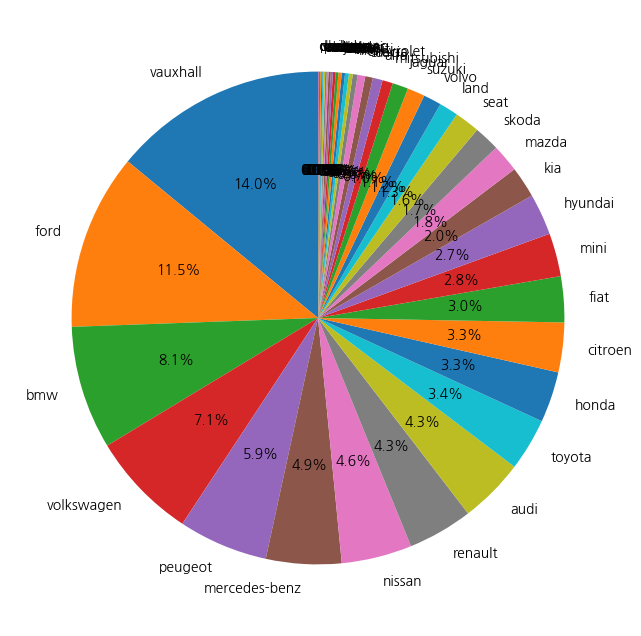

In [33]:
count=cars_df['브랜드'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(count, labels=count.index, autopct='%.1f%%', startangle=90)
plt.show()

In [34]:
cars_df.loc[cars_df['브랜드'].isin(cars_df['브랜드'].value_counts()[cars_df['브랜드'].value_counts() <=28].index),'브랜드']='others'
cars_df['브랜드'] = cars_df['브랜드'].astype('string')

### 모델명

In [35]:
cars_df['모델명']=cars_df['모델명'].astype('string')

### 국가

In [36]:
cars_df['국가'].value_counts(normalize=True)*100

국가
Germany           24.570201
United Kingdom    19.591691
Japan             15.759312
France            13.574499
United States     12.464183
South Korea        4.871060
Italy              3.868195
Czech Republic     1.683381
Spain              1.647564
Sweden             1.396848
Romania            0.501433
Malaysia           0.071633
Name: proportion, dtype: float64

In [37]:
cars_df['국가']= cars_df['국가'].astype('string')

### 요약
+ 연료
  'Petrol Hybrid', 'Petrol Plug-in Hybrid', 'Diesel Hybrid', 'Electric'의 값은 합쳐서 1% 미만의 비율을 차지하며, 특이 케이스에 해당하여 분석 결과에 왜곡을 가져올 수 있으므로 제거한다.  
  1%가 안 되는 값 제거하여 Petrol(휘발유), Diesel(경유)의 두 가지 값만 존재  
  `string` 변환, 상관관계 분석 후 원-핫 인코딩 진행  
+ 차체  
  `string` 변환  
+ 엔진  
  실수+'L'의 형식을 가지고 있다. 'L'을 제거  
  `float` 변환  
+ 기어  
  'Manual', 'Auotomatic' 두 가지의 값만 존재  
  `string` 변환, 상관관계 분석 후 원-핫 인코딩 진행  
+ 브랜드  
  28개 이하의 값, 즉 1% 미만을 차지하는 희소 카테고리는 시장 내 인지도가 낮고, 구매 시 브랜드보다 가격/기능이 우선될 가능성이 높아 Others로 처리하였다.  
  others에 해당하는 차량을 구매한 사람은 대중적이지 않은 결정을 한 사람으로, 브랜드 충성도보다는 가격/기능/취향 중심의 선택을 우선적으로 고려한 결정으로 본다.  
  `string` 변환, 상관관계 분석 후 원-핫 인코딩 진행
+ 국가
  비율이 적은 국가를 others로 변환하려 했으나 'Romania', 'Malayisia' 두 가지밖에 없기 때문에, 그대로 진행한다.
  `string` 변환, 상관관계 분석 후 원-핫 인코딩 진행

#### 데이터 크기
제거된 데이터 크기 : 21 rows (약 0.7%)  
남은 데이터 크기 : 2792 rows

## 이상치 탐지 및 처리

In [38]:
# 시각화를 위해서 결측치를 대체했던 값을 NaN으로 만들기
cars_df['이전 차주(명)']=cars_df['이전 차주(명)'].replace(99,np.nan)

### 판매 가격

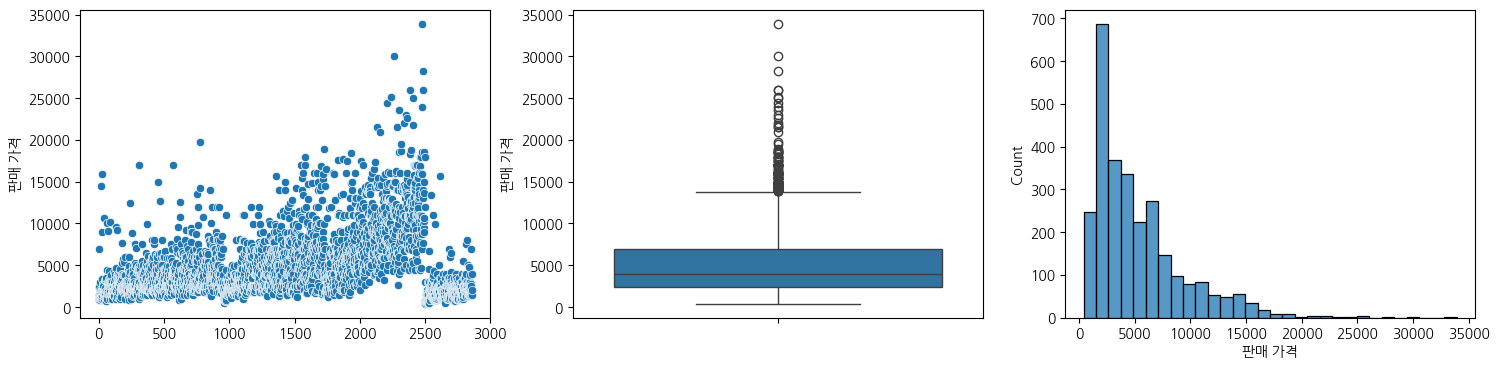

In [39]:
plt.figure(figsize=(18,4))
plt.subplot(131)
sns.scatterplot(cars_df['판매 가격'])
plt.subplot(132)
sns.boxplot(cars_df['판매 가격'])
plt.subplot(133)
sns.histplot(cars_df,x='판매 가격',bins=30)
plt.show()
# 2500대부터 갑자기 가격이 훅 떨어짐. 이게 만약 시계열 기반 데이터라면 2500선에서 정책, 외교, 법과 같은 외적요소의 영향이 있을지도.
# 2500대 이후로 차이나는 이유 찾아보기
# 몇가지의 높은 값이 있긴 하지만 이해가 안 되는 것이 아니기에, 상관관계를 분석해보고 비싼 모델의 자동차인지 판단 필요

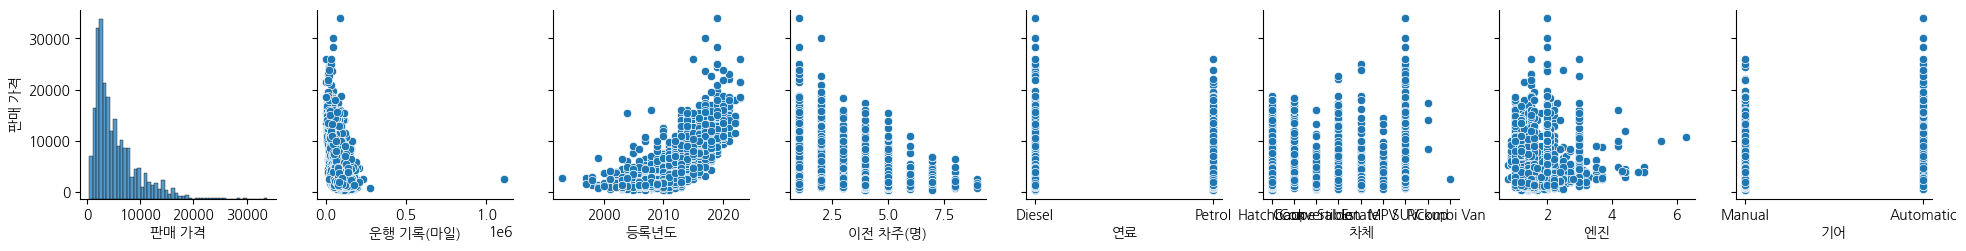

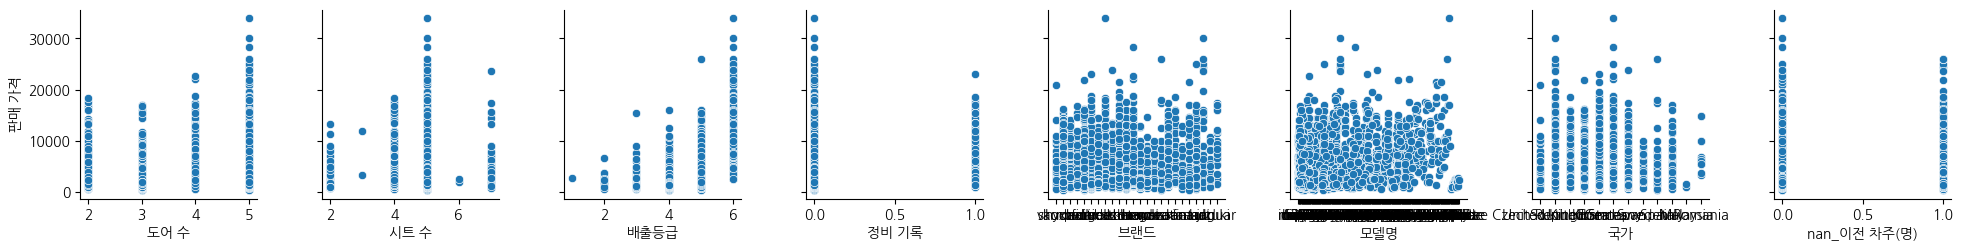

In [40]:
col1=cars_df.columns[:8]
col2=cars_df.columns[8:]
sns.pairplot(cars_df, y_vars=['판매 가격'], x_vars=col1)
sns.pairplot(cars_df, y_vars=['판매 가격'], x_vars=col2)
plt.show()
# 가장 높은 가격을 나타내는 데이터는 대체로 많은 산포도에서 높은 가격을 가지는 속성에 속해있다.
# 운행 기록은 이상치 제거를 한 후 다시 볼 필요가 있네.

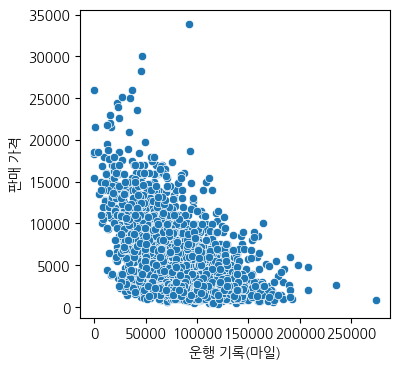

In [41]:
cars_df = cars_df.drop(cars_df[cars_df['운행 기록(마일)'] == cars_df['운행 기록(마일)'].max()].index)
plt.figure(figsize=(4,4))
sns.scatterplot(cars_df,x='운행 기록(마일)',y='판매 가격')
plt.show()

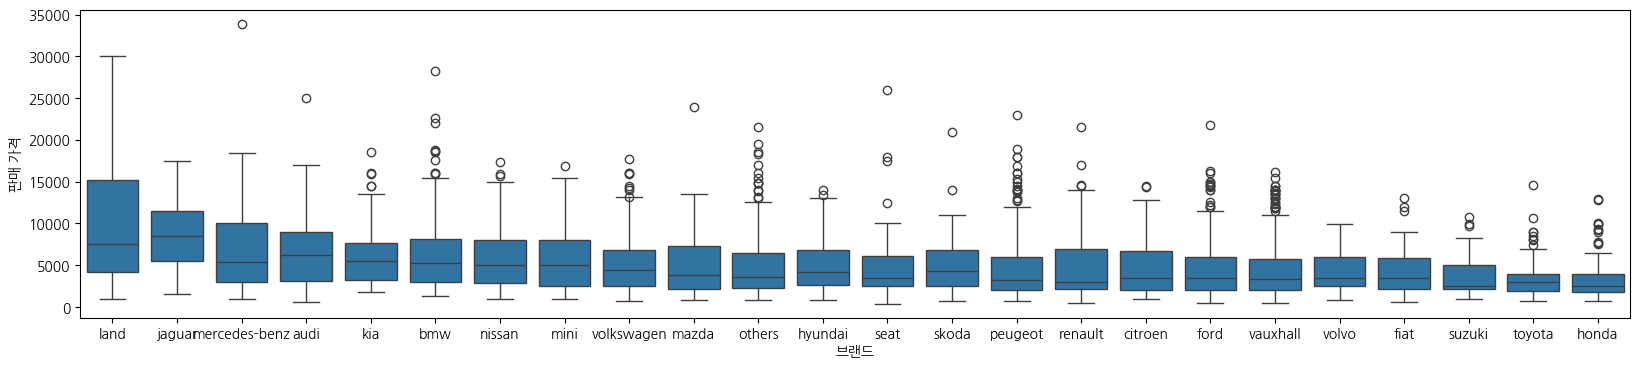

In [42]:
plt.figure(figsize=(20,4))
sns.boxplot(cars_df,x='브랜드',y='판매 가격',order=cars_df.groupby('브랜드')['판매 가격'].mean().sort_values(ascending=False).index)
plt.show()

In [43]:
cars_df = cars_df.drop(cars_df[cars_df['판매 가격'] == cars_df['판매 가격'].max()].index)

### 운행 기록(마일)

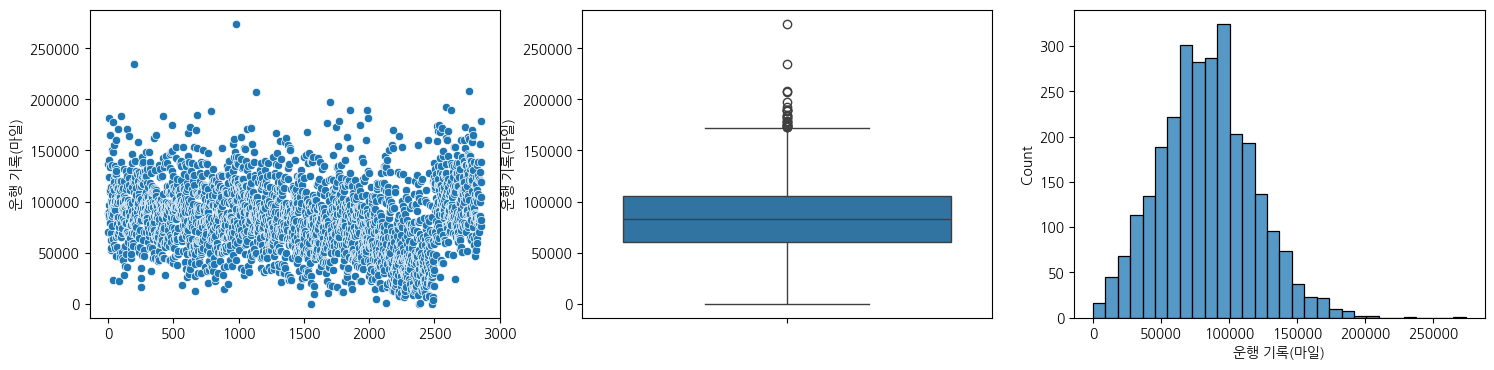

In [44]:
plt.figure(figsize=(18,4))
plt.subplot(131)
sns.scatterplot(cars_df['운행 기록(마일)'])
plt.subplot(132)
sns.boxplot(cars_df['운행 기록(마일)'])
plt.subplot(133)
sns.histplot(cars_df,x='운행 기록(마일)',bins=30)
plt.show()

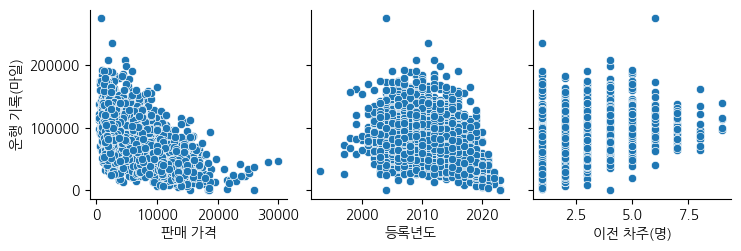

In [45]:
sns.pairplot(cars_df, y_vars=['운행 기록(마일)'], x_vars=cars_df[['판매 가격','등록년도','이전 차주(명)']].columns)
plt.show()

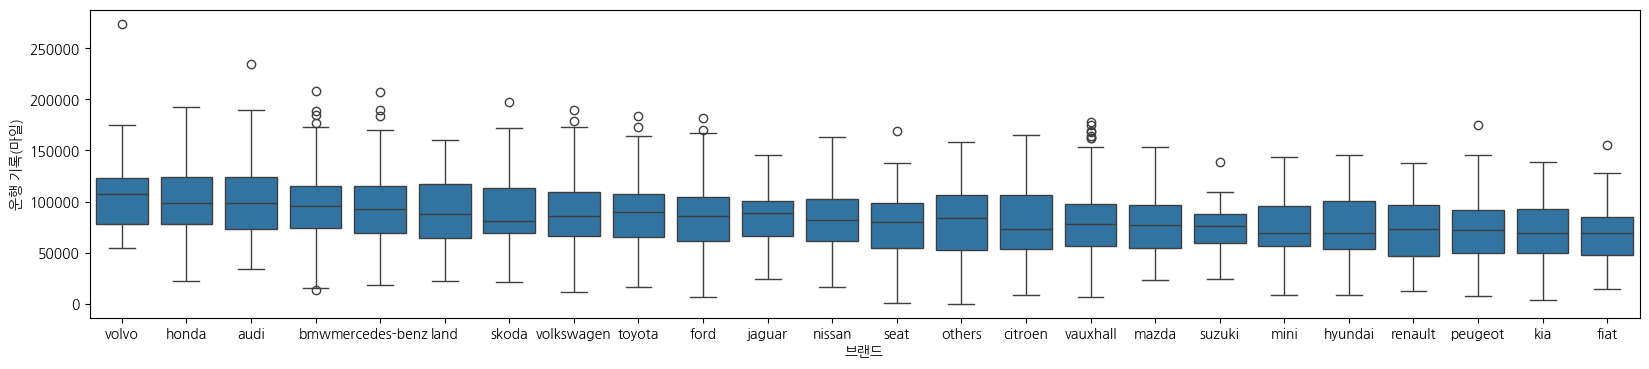

In [46]:
plt.figure(figsize=(20,4))
sns.boxplot(cars_df,x='브랜드',y='운행 기록(마일)',order=cars_df.groupby('브랜드')['운행 기록(마일)'].mean().sort_values(ascending=False).index)
plt.show()

In [47]:
cars_df.groupby('브랜드')['운행 기록(마일)'].min()['bmw']
# 13271 마일의 운행기록을 가진 bmw

np.int64(13271)

In [48]:
cars_df[cars_df['브랜드']=='bmw'].sort_values('운행 기록(마일)').head()

,판매 가격,운행 기록(마일),등록년도,이전 차주(명),연료,차체,엔진,기어,도어 수,시트 수,배출등급,정비 기록,브랜드,모델명,국가,nan_이전 차주(명)
2395,18798,13271,2020,1.0,Petrol,Hatchback,1.5,Manual,5.0,5.0,6.0,0,bmw,1,Germany,False
2336,21998,15744,2021,1.0,Petrol,Saloon,1.5,Manual,4.0,5.0,6.0,0,bmw,2,Germany,False
2358,22600,24098,2018,2.0,Diesel,Saloon,3.0,Automatic,4.0,5.0,6.0,0,bmw,3,Germany,False
2304,18499,24554,2019,1.0,Petrol,SUV,1.5,Manual,5.0,5.0,6.0,1,bmw,x1,Germany,False
1832,17599,26607,2019,NaN,Petrol,Coupe,1.5,Automatic,2.0,4.0,6.0,0,bmw,2,Germany,True


In [49]:
cars_df['운행 기록(마일)'].sort_values().head()

2384       1
2478       1
1555       6
2386     222
2129    1048
Name: 운행 기록(마일), dtype: int64

In [50]:
cars_df.loc[cars_df['운행 기록(마일)'].sort_values().head().index]

,판매 가격,운행 기록(마일),등록년도,이전 차주(명),연료,차체,엔진,기어,도어 수,시트 수,배출등급,정비 기록,브랜드,모델명,국가,nan_이전 차주(명)
2384,18365,1,2023,NaN,Petrol,SUV,1.5,Manual,5.0,5.0,6.0,0,others,mg,United Kingdom,True
2478,18515,1,2023,NaN,Petrol,SUV,1.5,Manual,5.0,5.0,6.0,0,others,mg,United Kingdom,True
1555,15500,6,2004,4.0,Petrol,Saloon,1.8,Manual,4.0,5.0,3.0,0,others,zt,United Kingdom,False
2386,25995,222,2023,NaN,Petrol,SUV,1.5,Manual,5.0,5.0,6.0,0,seat,ateca,Spain,True
2129,21495,1048,2023,1.0,Petrol,SUV,1.5,Automatic,5.0,5.0,6.0,0,others,mg,United Kingdom,False


In [51]:
cars_df=cars_df.drop(cars_df[cars_df['운행 기록(마일)'] < 100].index)

### 등록년도	

In [52]:
cars_df['등록년도'].value_counts().sort_index()

등록년도
1993      1
1997      3
1998      3
1999      5
2000      4
2001     16
2002     30
2003     50
2004     64
2005     79
2006    119
2007    176
2008    189
2009    213
2010    231
2011    239
2012    216
2013    231
2014    233
2015    174
2016    152
2017    104
2018     75
2019     80
2020     62
2021     28
2022      7
2023      3
Name: count, dtype: int64

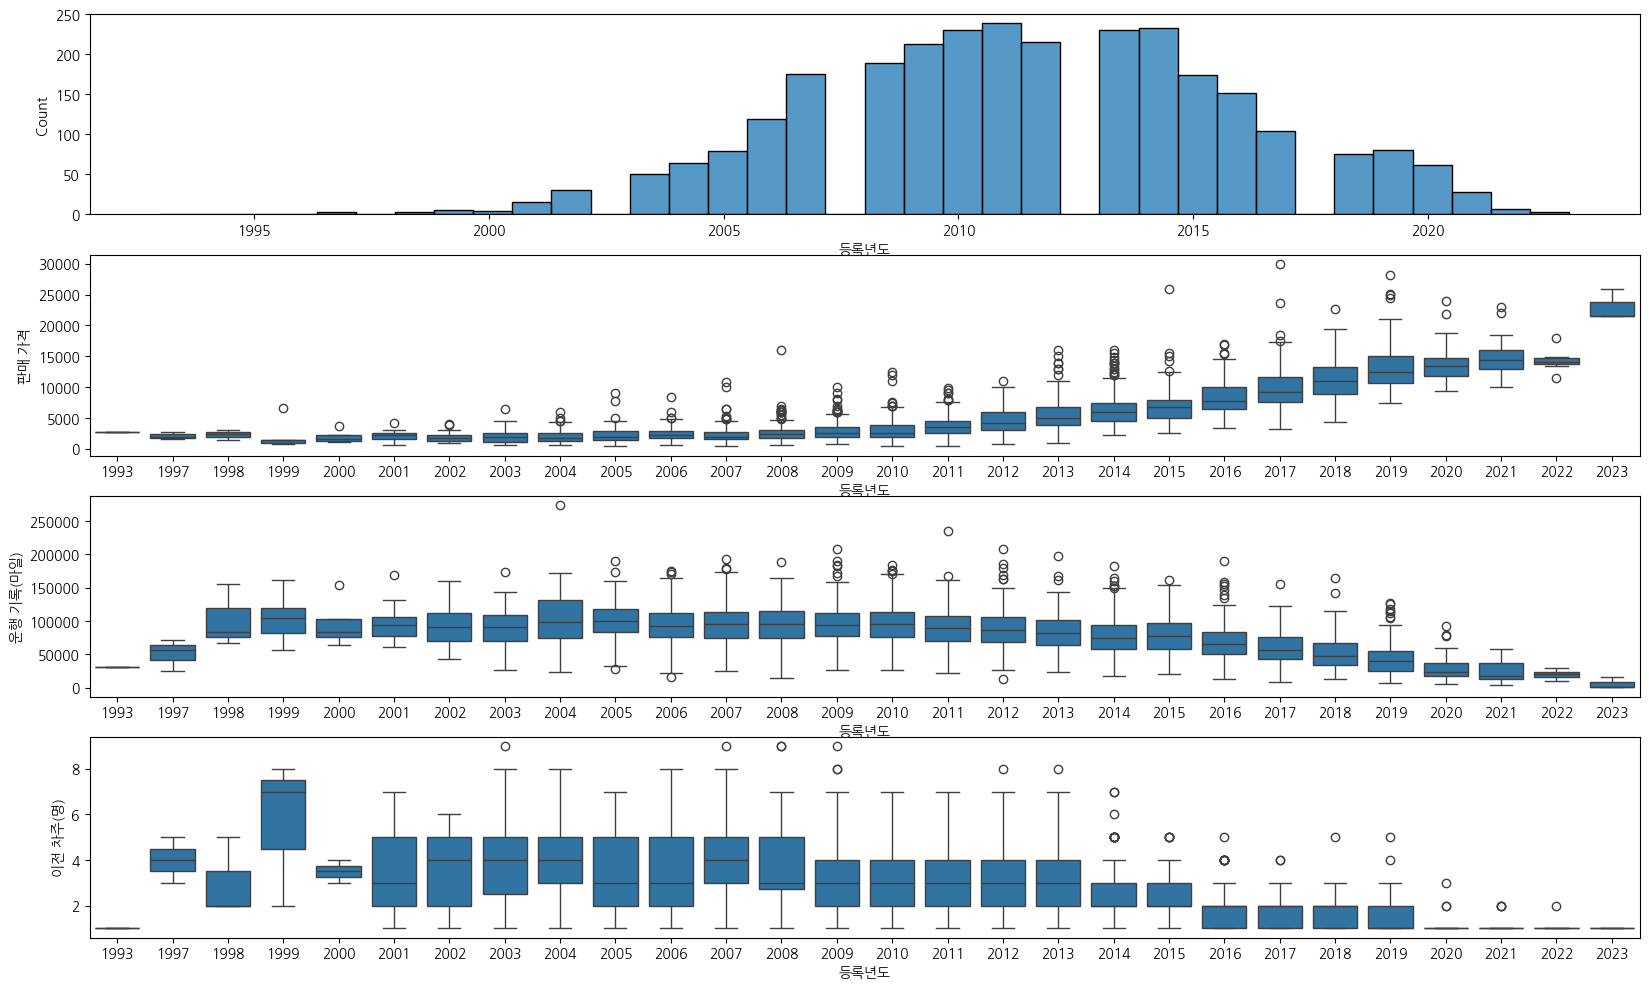

In [53]:
plt.figure(figsize=(20,12))
plt.subplot(411)
sns.histplot(cars_df,x='등록년도')
plt.subplot(412)
sns.boxplot(cars_df,x='등록년도',y='판매 가격')
plt.subplot(413)
sns.boxplot(cars_df,x='등록년도',y='운행 기록(마일)')
plt.subplot(414)
sns.boxplot(cars_df,x='등록년도',y='이전 차주(명)')
plt.show()

In [54]:
cars_df=cars_df.drop(cars_df[cars_df['등록년도']==1993].index)

### 이전 차주(명)

<Axes: xlabel='이전 차주(명)', ylabel='Count'>

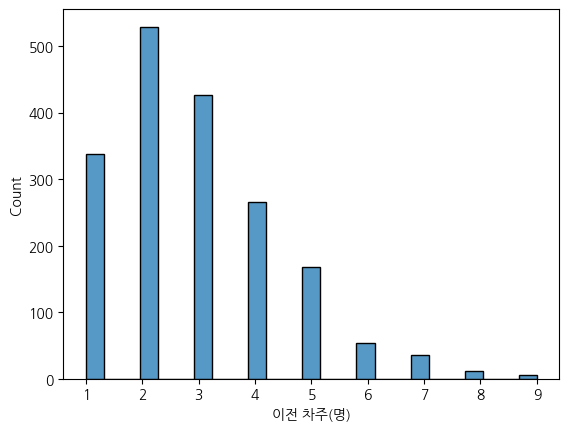

In [55]:
sns.histplot(cars_df['이전 차주(명)'])
# 이상 없음

### 요약
1. 판매 가격  
   다른 데이터에 비해 눈에 띄게 높은 가격을 가진 3개의 데이터를 발견하였다. 각각을 높은 순서대로 a,b,c 데이터라고 하겠다.  
   a,b,c 모두 대부분의 산포도에서 높은 가격대를 형성하는 집단에 속해있음을 확인할 수 있다.  
   그러나 브랜드별 판매 가격의 분포를 보았을 때
   + b의 경우는 'land'라는 브랜드에 속해있으며, boxplot의 이상치로 확인되지 않았다.
   + a의 경우는 해당 브랜드가 'mercedes-benz'이고, 평균 판매 가격이 3위인 브랜드이지만 IQR의 1.5배를 훨씬 뛰어넘으며, 운행기록과의 상관관계에서 역시 이상치로 판단하여 제거한다.
   + c의 경우는 브랜드 'bmw'에 속해있는 것으로 보이며, boxplot에서 이상치로 보이지만 다른 데이터와 비교해보아도 나올 수 있는 가격이라고 판단된다.<br><br>
3. 운행 기록(마일)  
   최고값은 '판매 가격'과의 산포도에서 이상치로 판단되어 제거하였다. 이후의 최고값은 상관관계에서 이상이 없음을 확인하였다.  
   bmw에서 IQR의 하한선을 넘는 데이터가 발견되었으나, 같은 브랜드에서 비교했을 때 이상치가 아닌 것으로 판단된다.  
   최저가 3개의 데이터에서 1,1,6 마일의 차량을 발견, 중고차 데이터에서 이는 불가능한 값이고 가격과의 상관관계도 부정확하므로 제거하였다.  
   
   브랜드별 운행 기록을 봤을 때, 사람들은 'volvo','honda','audi'- 등의 순서로 마일리지가 높아도 거래가 이루어짐을 확인할 수 있다.
5. 등록년도  
   1993년에서 하나의 데이터가 존재하며, 운행기록이 현저히 낮고 이전 차주 1명인 것으로 보아 차고에 방치되었을 차량으로 생각이된다.  
   이러한 경우 특수한 상황으로 중고차 시장의 경향을 제대로 반영할 수 없을 것으로 판단하여 제거한다.
7. 이전 차주(명)  
   이상 없음

# 상관관계

<Axes: >

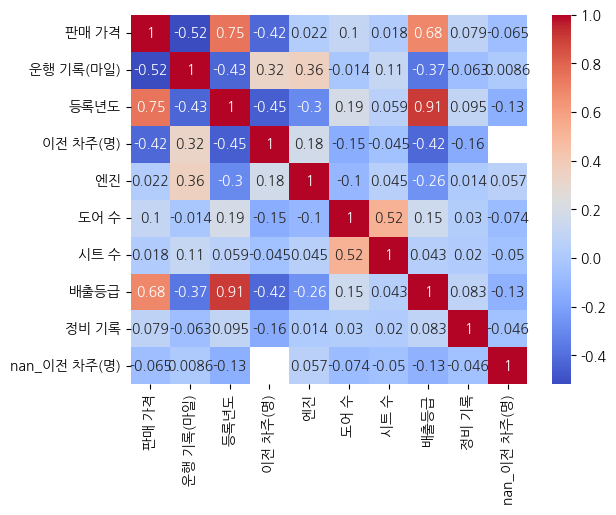

In [56]:
sns.heatmap(cars_df.corr(numeric_only=True),annot=True,cmap='coolwarm')

In [57]:
pca=PCA(1)
pca=pca.fit_transform(cars_df[['도어 수','시트 수']])
pca=pd.DataFrame(pca)
pca.columns=['차량 크기']
pca.head()

,차량 크기
0,0.666693
1,-1.187407
2,0.666693
3,-1.562344
4,0.666693


In [58]:
cars_df=cars_df.reset_index(drop=True)
cars_df=pd.concat([cars_df,pca],axis=1).drop(['도어 수','시트 수'],axis=1)

<Axes: >

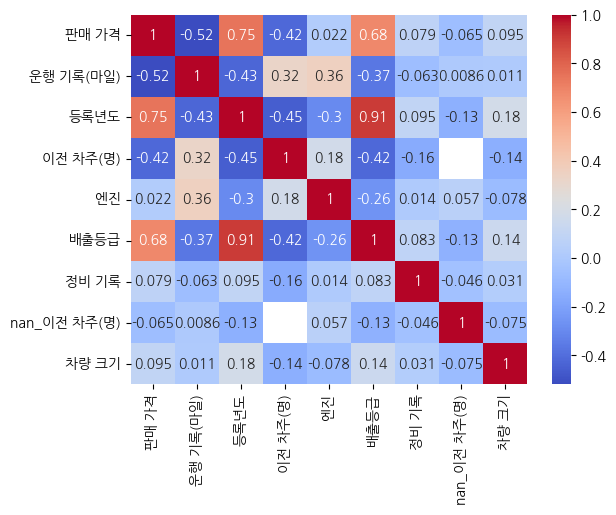

In [59]:
sns.heatmap(cars_df.corr(numeric_only=True),annot=True,cmap='coolwarm')

<Axes: xlabel='등록년도', ylabel='배출등급'>

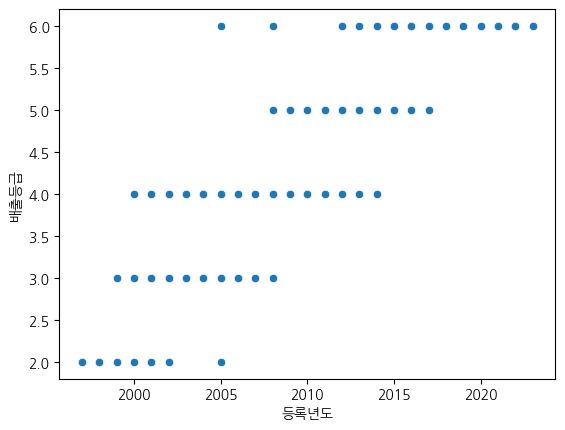

In [60]:
sns.scatterplot(cars_df,x='등록년도',y='배출등급')

## 요약
1. '차량 크기' 새로운 피쳐 생성  
   '도어 수'와 '시트 수'가 상관관계를 가진다. 이 의미를 해석했을 때 두 개의 요소가 하나로 합쳐 '차량 크기'라는 새로운 설명이 가능할 것으로 보인다. PCA를 활용하여 하나의 주성분으로 이를 표현하고 다시 상관관계를 분석해보았다.
   그러나, 차량 크기가 판매 가격에 영향을 미치지는 않는다.
2. 배출등급과 판매가격의 상관관계  
   두 개의 속성은 서로 큰 상관관계가 있는 것으로 보인다.  
   하지만 등록년도와 배출등급의 상관관계를 확인해봤을 때 등록년도가 최신일수록 배출등급이 높았으며, 이는 등록년도가 판매가격에 미치는 영향과 동일한 지표임을 확인하였다.
3. 판매 가격 : 운행 기록(마일), 이전 차주(명)  
   운행 기록과 이전 차주는 판매 가격과 음의 상관관계가 크게 나타났다.  
   **운행 기록이 적을수록, 이전 차주가 적을수록** 판매 가격이 높다.

# 원+핫 인코딩

In [61]:
cars_df['이전 차주(명)']=cars_df['이전 차주(명)'].fillna(cars_df['이전 차주(명)'].median())
cars_df.dtypes

판매 가격                    int64
운행 기록(마일)                int64
등록년도                     int64
이전 차주(명)               float64
연료              string[python]
차체              string[python]
엔진                     Float64
기어              string[python]
배출등급                   float64
정비 기록                    int64
브랜드             string[python]
모델명             string[python]
국가              string[python]
nan_이전 차주(명)              bool
차량 크기                  float64
dtype: object

In [62]:
cars_df['연료'].value_counts()

연료
Petrol    1789
Diesel     997
Name: count, dtype: Int64

In [63]:
cars_df['차체'].value_counts()

차체
Hatchback      1676
SUV             376
Saloon          291
MPV             130
Estate          118
Coupe           103
Convertible      88
Pickup            3
Combi Van         1
Name: count, dtype: Int64

In [64]:
cars_df['기어'].value_counts()

기어
Manual       2161
Automatic     625
Name: count, dtype: Int64

In [65]:
cars_df['브랜드'].value_counts()

브랜드
vauxhall         392
ford             322
bmw              226
volkswagen       195
peugeot          164
mercedes-benz    137
others           134
nissan           129
renault          119
audi             119
toyota            96
honda             93
citroen           91
fiat              84
mini              79
hyundai           76
kia               57
mazda             51
skoda             47
seat              46
land              35
volvo             33
suzuki            32
jaguar            29
Name: count, dtype: Int64

In [66]:
cars_df['국가'].value_counts()

국가
Germany           683
United Kingdom    544
Japan             440
France            379
United States     348
South Korea       136
Italy             108
Czech Republic     47
Spain              46
Sweden             39
Romania            14
Malaysia            2
Name: count, dtype: Int64

In [67]:
one_hot_df = pd.get_dummies(cars_df, columns=['연료','기어'],drop_first=True)
one_hot_df = pd.get_dummies(one_hot_df, columns=['차체','브랜드','국가'])
one_hot_df = one_hot_df.drop('모델명',axis=1)

In [68]:
one_hot_df

,판매 가격,운행 기록(마일),등록년도,이전 차주(명),엔진,배출등급,정비 기록,nan_이전 차주(명),차량 크기,연료_Petrol,...,국가_Germany,국가_Italy,국가_Japan,국가_Malaysia,국가_Romania,국가_South Korea,국가_Spain,국가_Sweden,국가_United Kingdom,국가_United States
0,6900,70189,2016,3.0,1.4,6.0,0,False,0.666693,False,...,False,False,False,False,False,False,False,False,False,False
1,1495,88585,2008,4.0,1.2,4.0,1,False,-1.187407,True,...,False,False,False,False,False,False,False,False,True,False
2,949,137000,2011,3.0,1.4,5.0,0,True,0.666693,True,...,False,False,False,False,False,True,False,False,False,False
3,2395,96731,2010,5.0,1.4,4.0,1,False,-1.562344,True,...,False,False,False,False,False,False,False,False,True,False
4,1000,85000,2013,3.0,1.3,5.0,0,True,0.666693,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2781,1395,76202,2006,4.0,1.6,4.0,0,False,0.666693,True,...,False,False,False,False,False,False,False,False,False,False
2782,6990,119000,2012,3.0,2.0,5.0,0,True,-0.260357,True,...,True,False,False,False,False,False,False,False,False,False
2783,3995,139000,2013,3.0,2.0,5.0,0,True,-0.260357,False,...,True,False,False,False,False,False,False,False,False,False
2784,1390,179190,2007,3.0,2.2,4.0,1,True,0.666693,False,...,False,False,True,False,False,False,False,False,False,False


# 스케일링

<Axes: xlabel='판매 가격', ylabel='Count'>

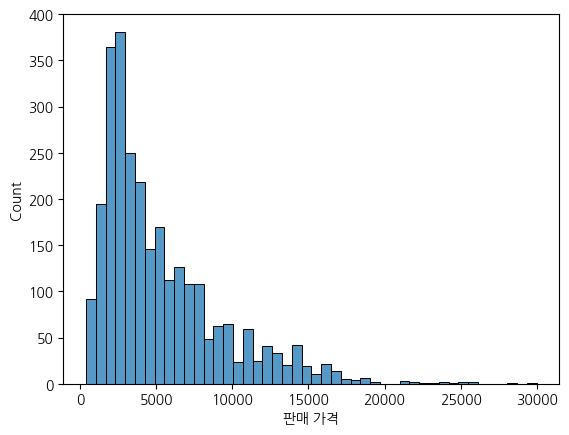

In [69]:
sns.histplot(one_hot_df['판매 가격'])

In [70]:
rs = RobustScaler()
rs.fit(one_hot_df)
rs_df=pd.DataFrame(rs.transform(one_hot_df),index=one_hot_df.index,columns=one_hot_df.columns)

In [71]:
ss = StandardScaler()
ss.fit(one_hot_df)
ss_df=pd.DataFrame(ss.transform(one_hot_df),index=one_hot_df.index,columns=one_hot_df.columns)

## 요약
오른쪽으로 긴 꼬리를 가진 분포의 그래프이다.  
따라서, 정규분포에 유리한 StandardScaler보다는 RobustScaler를 활용하여 중앙값에 기반한 계산을 하는 것이 분포를 더 잘 설명할 수 있을 것이다.

# 주성분 분석

In [72]:
rs_df

,판매 가격,운행 기록(마일),등록년도,이전 차주(명),엔진,배출등급,정비 기록,nan_이전 차주(명),차량 크기,연료_Petrol,...,국가_Germany,국가_Italy,국가_Japan,국가_Malaysia,국가_Romania,국가_South Korea,국가_Spain,국가_Sweden,국가_United Kingdom,국가_United States
0,0.639855,-0.297100,0.833333,0.0,-0.285714,1.0,0.0,0.0,0.000000,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.549626,0.111700,-0.500000,1.0,-0.571429,-1.0,1.0,0.0,-1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.669784,1.187589,0.000000,0.0,-0.285714,0.0,0.0,1.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.351562,0.292722,-0.166667,2.0,-0.285714,-1.0,1.0,0.0,-1.202221,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.658561,0.032033,0.333333,0.0,-0.428571,0.0,0.0,1.0,0.000000,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2781,-0.571633,-0.163478,-0.833333,1.0,0.000000,-1.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2782,0.659661,0.787589,0.166667,0.0,0.571429,0.0,0.0,1.0,-0.500000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2783,0.000550,1.232033,0.333333,0.0,0.571429,0.0,0.0,1.0,-0.500000,-1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2784,-0.572733,2.125144,-0.666667,0.0,0.857143,-1.0,1.0,1.0,0.000000,-1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
pca=PCA(7)

pca.fit(rs_df)

pd.DataFrame(pca.transform(one_hot_df))

,0,1,2,3,4,5,6
0,15624.684888,-7875.342532,20652.221841,45741.531473,-17976.766316,-6078.442663,-1660.224347
1,23071.316602,-12506.536935,23955.481014,59561.398437,-23716.222736,-7068.928583,-2615.461125
2,36706.330387,-20122.112644,36665.268705,92237.234268,-36787.176653,-10842.880479,-4138.289869
3,24934.364015,-13455.450739,26385.097819,64790.438252,-25768.551872,-7788.507069,-2800.092162
4,22291.275527,-12120.274696,22857.560130,57289.337894,-22827.288422,-6743.816154,-2540.654575
...,...,...,...,...,...,...,...
2781,19688.330929,-10639.254740,20634.752337,51269.433762,-20406.751723,-6084.856580,-2243.189585
2782,29097.235249,-15341.344293,33654.662118,78507.321085,-31060.729100,-9936.881345,-3149.654141
2783,35934.652017,-19411.640562,38092.428751,92755.710786,-36872.262875,-11259.883251,-3979.382303
2784,48193.608946,-26454.367048,48010.996624,120460.990346,-48040.986465,-14208.524536,-5399.926078


In [86]:
(pca.explained_variance_ratio_).sum()

np.float64(0.7164060201193496)

# 회고

1. 이번 분석에서는 보고서 작성의 편리성을 위해서 데이터를 불러올 때 컬럼을 한글화해보았다. 작성하는 입장, 보고서를 보는 입장에서는 한글이 오해의 여지가 적기 때문에 편리했으나, 협업의 과정에서는 영어로 진행(글로벌 기업의 경우)하거나 사전의 합의가 필요해보인다.
2. 결측치 처리에서 시간을 많이 소요하였다. 결측치를 최대한 채워넣는 것이 맞는지, 결측치를 제거해도 되는지, 결측 여부를 판단하는 피쳐를 생성하고 결측치를 채워도 모델링에 문제가 없는지.  
   데이터 비율이 상당히 적을 때에는 제거를 하는 것이 데이터를 깔끔하게 이용하는 방법이며, 결측치 비율이 너무 높으면 indicator을 사용하고 결측을 해결하는 방법을 찾는 것이 도움이 될 것 같았다.
3. 데이터를 다른 중복되는 이름에서 따오는 방식으로 결측치를 일부 보충하였다. 이런 것처럼 결측치를 창의적으로(논리가 맞다면) 해결하는 방법을 찾는 연습을 해야겠다.
4. 서로 연관이 있는 데이터(도어 수, 시트 수)를 병합하여 '차량 크기'라는 새로운 피쳐를 만드는 시도를 해봤다. 이전의 두 개의 데이터가 상관관계가 없다면 주성분을 이용해 만든 새 피쳐 역시 큰 상관관계가 없는 것 같았다.